# Vu 2024 demo



This tutorial demonstrates how to access an NWB file from the Vu 2024 dataset using `pynwb`.

This dataset contains fiber photometry recordings from multi-fiber arrays implanted in the striatum of head-fixed mice running on a treadmill.

Contents:

- [Streaming an NWB file](#stream-nwb)
- [Access Subject metadata](#access-subject)
- [Access Imaging data](#access-imaging)
- [Access raw fiber photometry data](#access-fiber-photometry)
- [Access processed fiber photometry data](#access-processed-fiber-photometry)
- [Access motion corrected imaging data](#access-motion-corrected)
- [Access behavior](#access-behavior)


# Steaming an NWB file <a name="stream-nwb"></a>

This section demonstrates how to access the files on the [DANDI Archive](https://dandiarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.


In [3]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient.for_dandi_instance("dandi")

dandiset_id = "001084"
file_path = "sub-DL18/sub-DL18_ses-211110_image+ophys.nwb"

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)


We will use `remfile` for streaming the file. You can read more about `remfile` at [this tutorial section](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#method-3-remfile).

In [5]:
import h5py
from pynwb import NWBHDF5IO
import remfile

# We stream the file using remfile and open it with h5py and pynwb
file = remfile.File(s3_url)
h5_file = h5py.File(file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)

nwbfile = io.read()

# Access subject metadata <a name="access-subject"></a>

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWBFile.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.

In [6]:
nwbfile.subject

subject pynwb.file.Subject at 0x5086803472
Fields:
  age__reference: birth
  date_of_birth: 2021-04-21 00:00:00-04:00
  genotype: wildtype
  sex: F
  species: Mus musculus
  strain: C57BL/6J - Jackson Labs 000664
  subject_id: DL18

# Access imaging <a name="access-imaging"></a>

This section demonstrates how to access the imaging data in the NWBFile.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Fiber array imaging

The two-photon imaging was acquired using HCImage Live (Hamamatsu) at 30 Hz. It is stored in a [pynwb.ophys.TwoPhotonSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.TwoPhotonSeries) object which is added to `nwbfile.acquisition`.


In [7]:
two_photon_series = nwbfile.acquisition["TwoPhotonSeriesGreen"]
two_photon_series

TwoPhotonSeriesGreen pynwb.ophys.TwoPhotonSeries at 0x4992189968
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (40000, 376, 375), type "<u2">
  description: Two-photon imaging acquired at 30 Hz with Hamamatsu microscope.
  dimension: <HDF5 dataset "dimension": shape (2,), type "<i8">
  imaging_plane: ImagingPlaneGreen pynwb.ophys.ImagingPlane at 0x5086801232
Fields:
  conversion: 1.0
  description: Imaging plane for the two-photon microscope.
  device: HamamatsuMicroscope pynwb.device.Device at 0x5086867216
Fields:
  manufacturer: Hamamatsu Photonics

  excitation_lambda: 470.0
  indicator: dLight1.3b
  location: STR
  optical_channel: (
    Green <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (40000,), type "<f8">
  timestamps_unit: seconds
  unit: n.a.

The information about the imaging plane can accessed as `nwbfile.acquisition["TwoPhotonSeries"].imaging_plane` or `nwbfile.imaging_planes["ImagingPlane"]`.

In [ ]:
nwbfile.imaging_planes["ImagingPlaneGreen"]

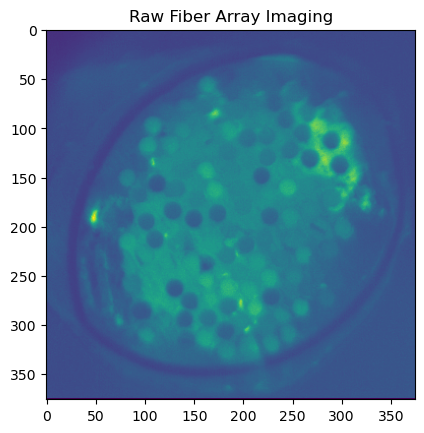

In [8]:
# Visualize the imaging data.

from matplotlib import pyplot as plt

frame = two_photon_series.data[50]
plt.imshow(frame)
plt.title("Raw Fiber Array Imaging")
plt.show()

# Fiber photometry traces

The raw fluorescence traces from the multi-fiber array are added to `nwbfile.acquisition` and are stored in a `FiberPhotometryResponseSeries` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry). The fluorescence data during 470 nm excitation can be accessed as `nwbfile.acquisition["FiberPhotometryResponseSeriesGreen"]`.

In [9]:
fiber_photometry_response_series = nwbfile.acquisition["FiberPhotometryResponseSeriesGreen"]

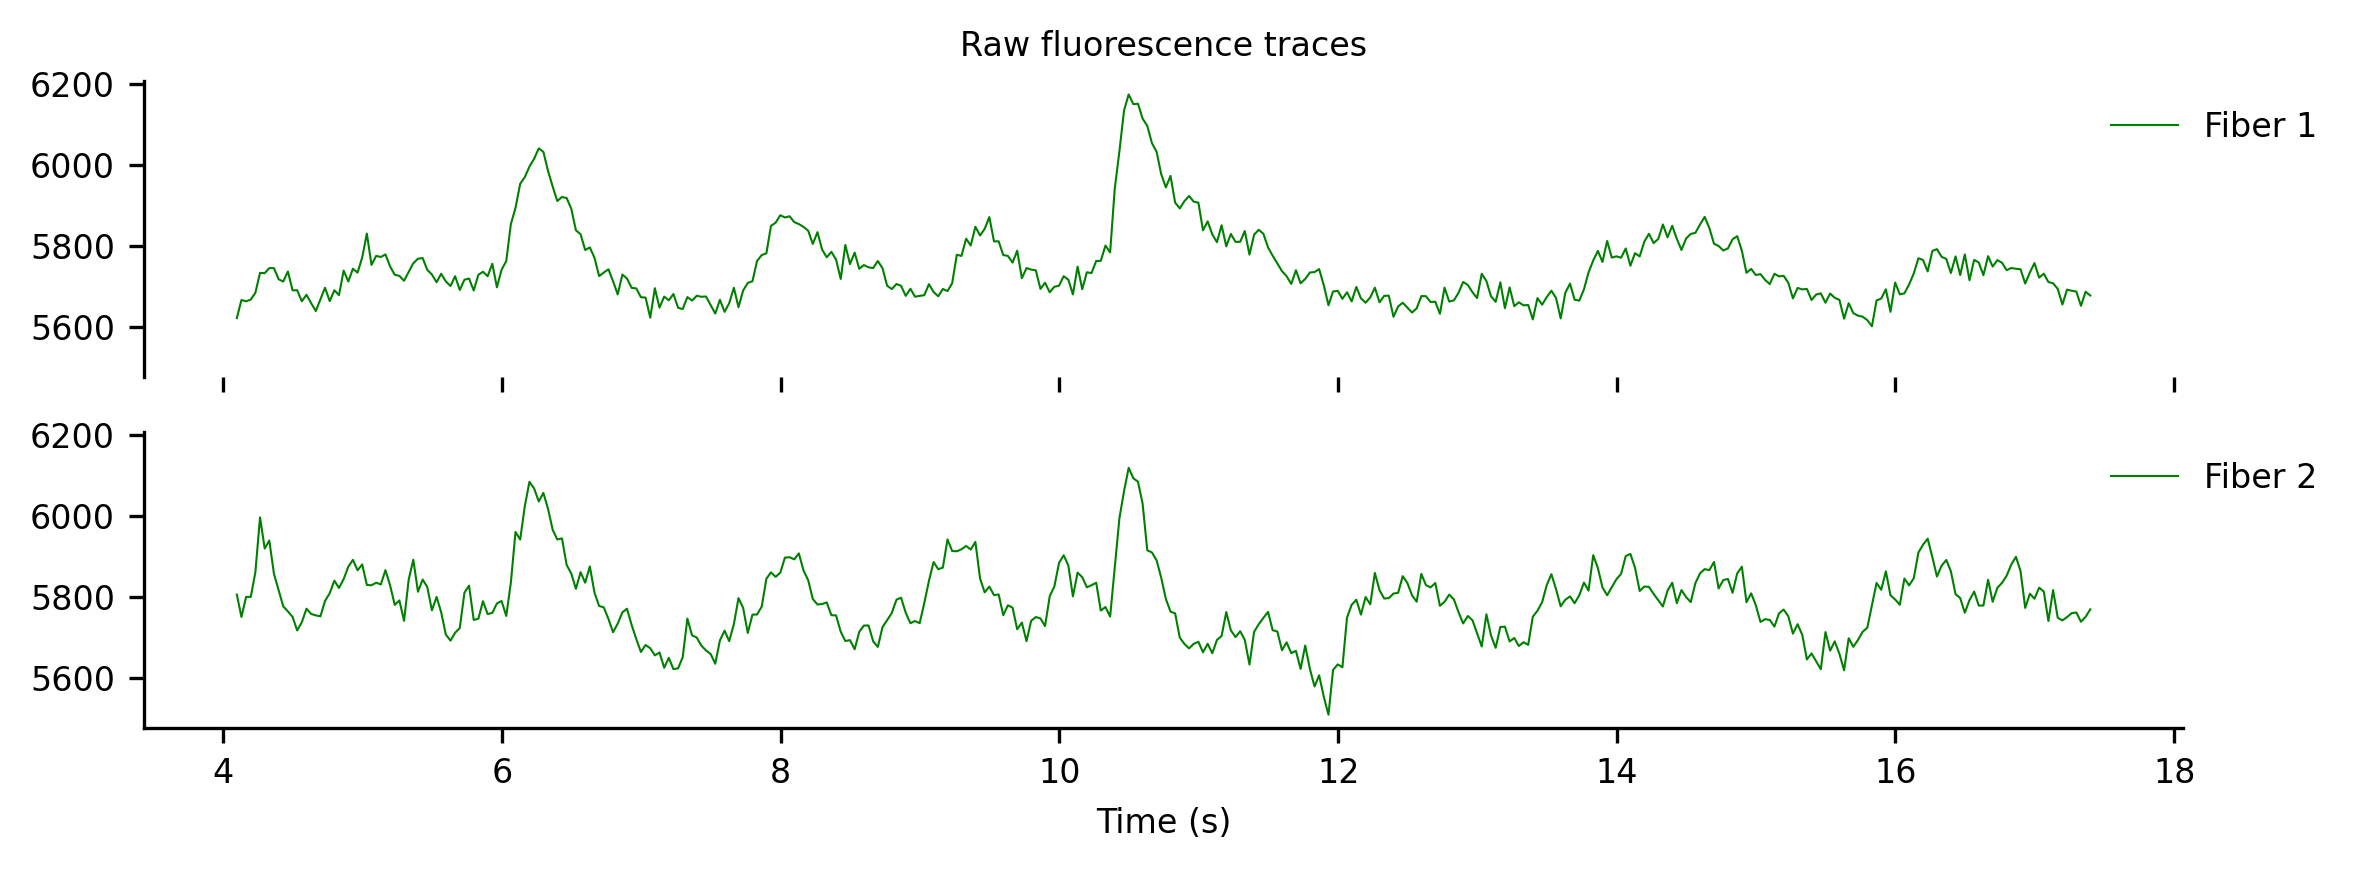

In [10]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
fiber_indices = [0, 4]
data = fiber_photometry_response_series.data[100:500, fiber_indices]
timestamps = fiber_photometry_response_series.get_timestamps()[100:500]

fig, axes = plt.subplots(nrows=data.shape[1], ncols=1, figsize=(8, 3), sharey=True, sharex=True, dpi=300)

for i, ax in enumerate(axes):
    ax.plot(timestamps, data[:, i], linewidth=0.5, color="green")

    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

    ax.legend([f"Fiber {i+1}"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].spines['bottom'].set_visible(False)
axes[0].set_title("Raw fluorescence traces", fontsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()


## Fiber photometry metadata

The fiber photometry metadata includes the type of indicator(s), optical fiber(s), excitation source(s), photodector(s), dichroic mirror(s), and optical filter(s) that were used to construct a single fluorescence signal.

The metadata is stored in a `FiberPhotometryTable` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry) and is added to `nwbfile.lab_meta_data`. It can be accessed as `nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table`.

In [11]:
nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table[:]

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,allen_atlas_coordinates,included,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,
0,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[442, 644, 229]",False,"[0.83, 0.74, 1.78]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
1,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[454, 642, 304]",False,"[0.71, 0.72, 2.44]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
2,Primary motor area Layer 6a,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[460, 674, 180]",False,"[0.65, 1.04, 1.35]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
3,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[495, 685, 260]",False,"[0.3, 1.15, 2.05]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
4,Primary motor area Layer 6a,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[400, 686, 160]",False,"[1.25, 1.16, 1.17]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
...,...,...,...,...,...,...,...,...,...,...,...
98,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[433, 775, 249]",False,"[0.92, 2.05, 1.96]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
99,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[444, 815, 381]",True,"[0.81, 2.45, 3.12]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
100,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[457, 833, 280]",False,"[0.68, 2.63, 2.23]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...


The `fiber_photometry_table_region` attribute in the `FiberPhotometryResponseSeries` object references row(s) of this table:

In [13]:
fiber_photometry_table_region = nwbfile.acquisition["FiberPhotometryResponseSeriesGreen"].fiber_photometry_table_region[:]
fiber_photometry_table_region.head()

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,allen_atlas_coordinates,included,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,
0,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[442, 644, 229]",False,"[0.83, 0.74, 1.78]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
1,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[454, 642, 304]",False,"[0.71, 0.72, 2.44]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
2,Primary motor area Layer 6a,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[460, 674, 180]",False,"[0.65, 1.04, 1.35]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
3,Caudoputamen,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[495, 685, 260]",False,"[0.3, 1.15, 2.05]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...
4,Primary motor area Layer 6a,dLight1.3b abc.Indicator at 0x5086798992\nFiel...,FiberArray abc.OpticalFiber at 0x5086856208\nF...,ExcitationSource470 abc.ExcitationSource at 0x...,CMOSCamera abc.Photodetector at 0x4993328208\n...,DichroicMirror1 abc.DichroicMirror at 0x508679...,"[400, 686, 160]",False,"[1.25, 1.16, 1.17]",OpticalFilter525 abc.BandOpticalFilter at 0x50...,OpticalFilter470 abc.BandOpticalFilter at 0x50...


The metadata on the optical fiber used to record the GCaMP fluorescence is added to `nwbfile.devices` and can be accessed as `nwbfile.devices["FiberArray"]` or can be accessed from the referenced optical fiber in the `fiber_photometry_table_region` of the `FiberPhotometryResponseSeries`.

In [14]:
fiber_photometry_table_region["optical_fiber"][0]

FiberArray abc.OpticalFiber at 0x5086856208
Fields:
  core_diameter_in_um: 34.0
  description: The optical fiber used in a multi-fiber arrays configuration, fabricated in-house to enable large scale measurements across deep brain volumes. Bare fibers were cut into pieces (ca. 3cm) then mounted under a microscope into 55-60μm diameter holes in a custom 3D printed grid (3mm W x 5mm L, Boston Micro Fabrication), measured under a dissection microscope to target a particular depth beneath the grid, and secured in place with UV glue (Norland Optical Adhesive 61). Each array contained between 30 and 103 fibers separated by a minimum of 220μm radially and 250μm axially. Separation was calculated to achieve maximal coverage of the striatum volume with no overlap in the collection fields of individual fibers. Fibers were cut with a fiber scribe, and the distal ends were inspected to ensure a uniform cut, and re-cut as necessary. Distal ends were then glued inside an 1cm ca. section of polyimide tube (0.8-1.3mm diameter, MicroLumen) then cut with a fresh razorblade. The bundled fibers inside the tube were then polished on fine grained polishing paper (ThorLabs,polished first with 6 μm, followed by 3 μm) to create a smooth, uniform fiber bundle surface for imaging. A larger diameter post was mounted on one side of the plastic grid to facilitate holding during implantation.
  manufacturer: Fiber Optics Tech
  model: not specified
  numerical_aperture: 0.66

In [15]:
fiber_photometry_table_region["indicator"][0]

dLight1.3b abc.Indicator at 0x5086798992
Fields:
  description: green dopamine sensor
  label: pAAV-CAG-dLight1.3b(AAV5)

In [16]:
fiber_photometry_table_region["excitation_source"][0]

ExcitationSource470 abc.ExcitationSource at 0x5086856848
Fields:
  description: Blue excitation light (470 nm LED, Thorlabs, No. SOLIS-470C) and violet excitation light (for the isosbestic control)
were coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.
Then, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,
each filtered with a corresponding filter.

  excitation_wavelength_in_nm: 470.0
  illumination_type: LED
  manufacturer: Thorlabs
  model: SOLIS-470C

In [17]:
fiber_photometry_table_region["photodetector"][0]

CMOSCamera abc.Photodetector at 0x4993328208
Fields:
  description: A tube lens in each path (Thor labs, No TTL165-A, detected wavelength bandwidth 350-700 nm) focused emission light onto the CMOS sensors of the cameras to form an image of the fiber bundle.
  detected_wavelength_in_nm: 525.0
  detector_type: CMOS sensor
  manufacturer: Hamamatsu Photonics
  model: Orca Fusion BT Gen III

In [18]:
fiber_photometry_table_region["dichroic_mirror"][0]

DichroicMirror1 abc.DichroicMirror at 0x5086798096
Fields:
  cut_on_wavelength_in_nm: 532.0
  description: The dichroic mirror used to reflect green and pass red fluorescence
  manufacturer: Chroma Tech Corp
  model: ZT532rdc
  reflection_band_in_nm: [405. 532.]
  transmission_band_in_nm: [545. 750.]

In [19]:
fiber_photometry_table_region["emission_filter"][0]

OpticalFilter525 abc.BandOpticalFilter at 0x5087064528
Fields:
  bandwidth_in_nm: 50.0
  center_wavelength_in_nm: 525.0
  description: The band-pass filter used to isolate the green emitted light after passing through a dichroic (Chroma, No. 532rdc) that reflected green and passed red fluorescence.
  filter_type: Bandpass
  manufacturer: Chroma
  model: 525/50m

In [20]:
fiber_photometry_table_region["excitation_filter"][0]

OpticalFilter470 abc.BandOpticalFilter at 0x5086931664
Fields:
  bandwidth_in_nm: 24.0
  center_wavelength_in_nm: 473.0
  description: The band-pass filter used to isolate the 470 nm excitation light.
  filter_type: Bandpass
  manufacturer: Chroma
  model: ET473/24

# Access processed fiber photometry data <a name="access-processed-fiber-photometry"></a>

This section demonstrates how to access the processed fiber photometry data in the NWBFile.

The processed fiber photometry data is stored in "processing/ophys" which can be accessed as `nwbfile.processing["ophys"]`. Within this processing module we can access the ∆F/F traces as `nwbfile.processing["ophys"]["DfOverFFiberPhotometryResponseSeriesGreen"]`.

In [23]:
nwbfile.processing["ophys"]

In [24]:
df_over_f_traces = nwbfile.processing["ophys"]["DfOverFFiberPhotometryResponseSeriesGreen"]
df_over_f_traces

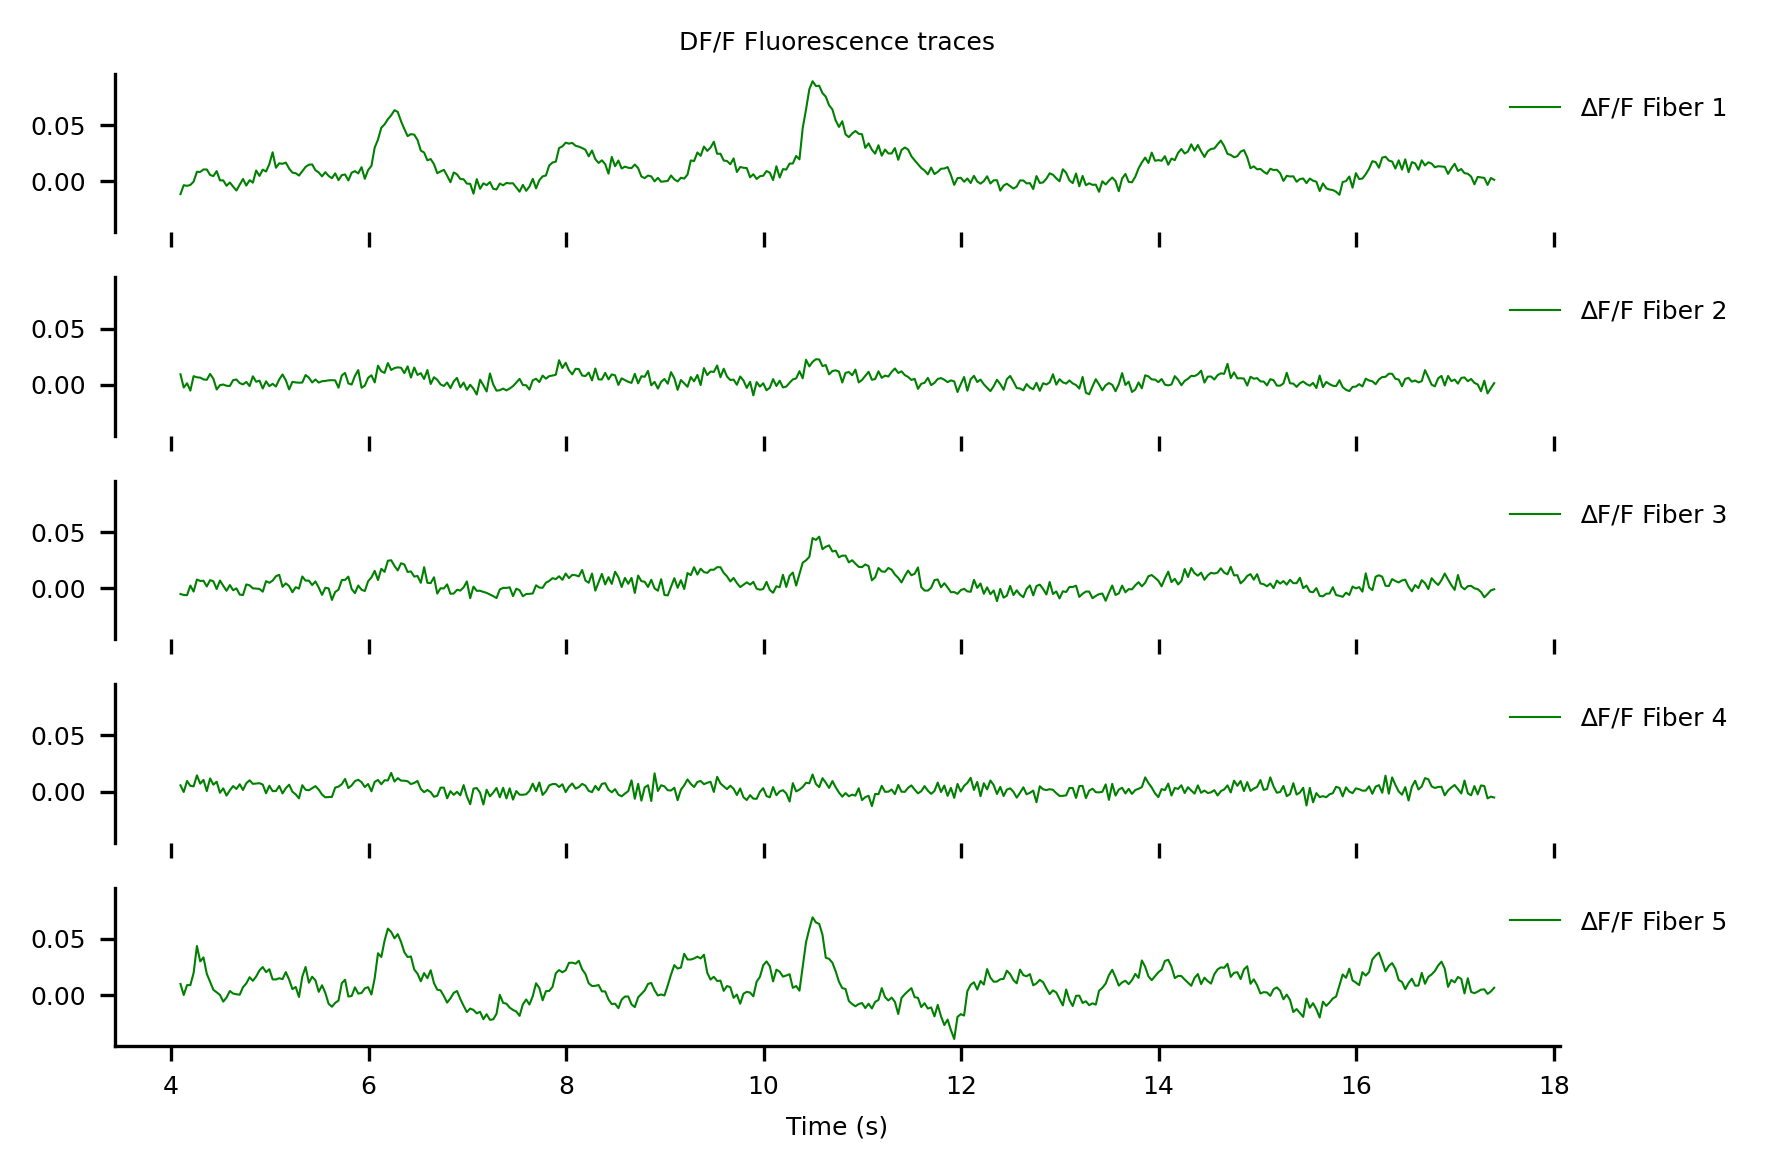

In [25]:
# Visualize the DF/F traces.

import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = df_over_f_traces.data[100:500, :5]
timestamps = df_over_f_traces.get_timestamps()[100:500]

fig, axes = plt.subplots(nrows=data.shape[1], ncols=1, figsize=(6, 4), sharey=True, sharex=True, dpi=300)

for i, ax in enumerate(axes):
    ax.plot(timestamps, data[:, i], linewidth=0.5, color="green")

    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='x', labelsize=6)

    ax.legend([f"∆F/F Fiber {i+1}"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 6})

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i != data.shape[1] - 1:
        ax.spines['bottom'].set_visible(False)

axes[0].set_title("DF/F Fluorescence traces", fontsize=6)
plt.xlabel('Time (s)', fontsize=6)
plt.tick_params(axis='x', labelsize=6)

plt.tight_layout()
plt.show()

# Access motion corrected imaging data <a name="access-motion-corrected"></a>

This section demonstrates how to access the motion corrected imaging data in the NWBFile.

Similarly to the raw imaging data, the processed imaging data is stored in a [pynwb.ophys.TwoPhotonSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.TwoPhotonSeries) object and is added to `nwbfile.processing["ophys"]`.

In [26]:
motion_corrected = nwbfile.processing["ophys"]["TwoPhotonSeriesMotionCorrectedGreen"]
motion_corrected

TwoPhotonSeriesMotionCorrectedGreen pynwb.ophys.TwoPhotonSeries at 0x5086803536
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (40000, 381, 378), type "<u2">
  description: The motion corrected two-photon imaging data.
  dimension: <HDF5 dataset "dimension": shape (2,), type "<i8">
  imaging_plane: ImagingPlaneGreen pynwb.ophys.ImagingPlane at 0x5086801232
Fields:
  conversion: 1.0
  description: Imaging plane for the two-photon microscope.
  device: HamamatsuMicroscope pynwb.device.Device at 0x5086867216
Fields:
  manufacturer: Hamamatsu Photonics

  excitation_lambda: 470.0
  indicator: dLight1.3b
  location: STR
  optical_channel: (
    Green <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  offset: 0.0
  rate: 29.994900866852635
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: n.a.

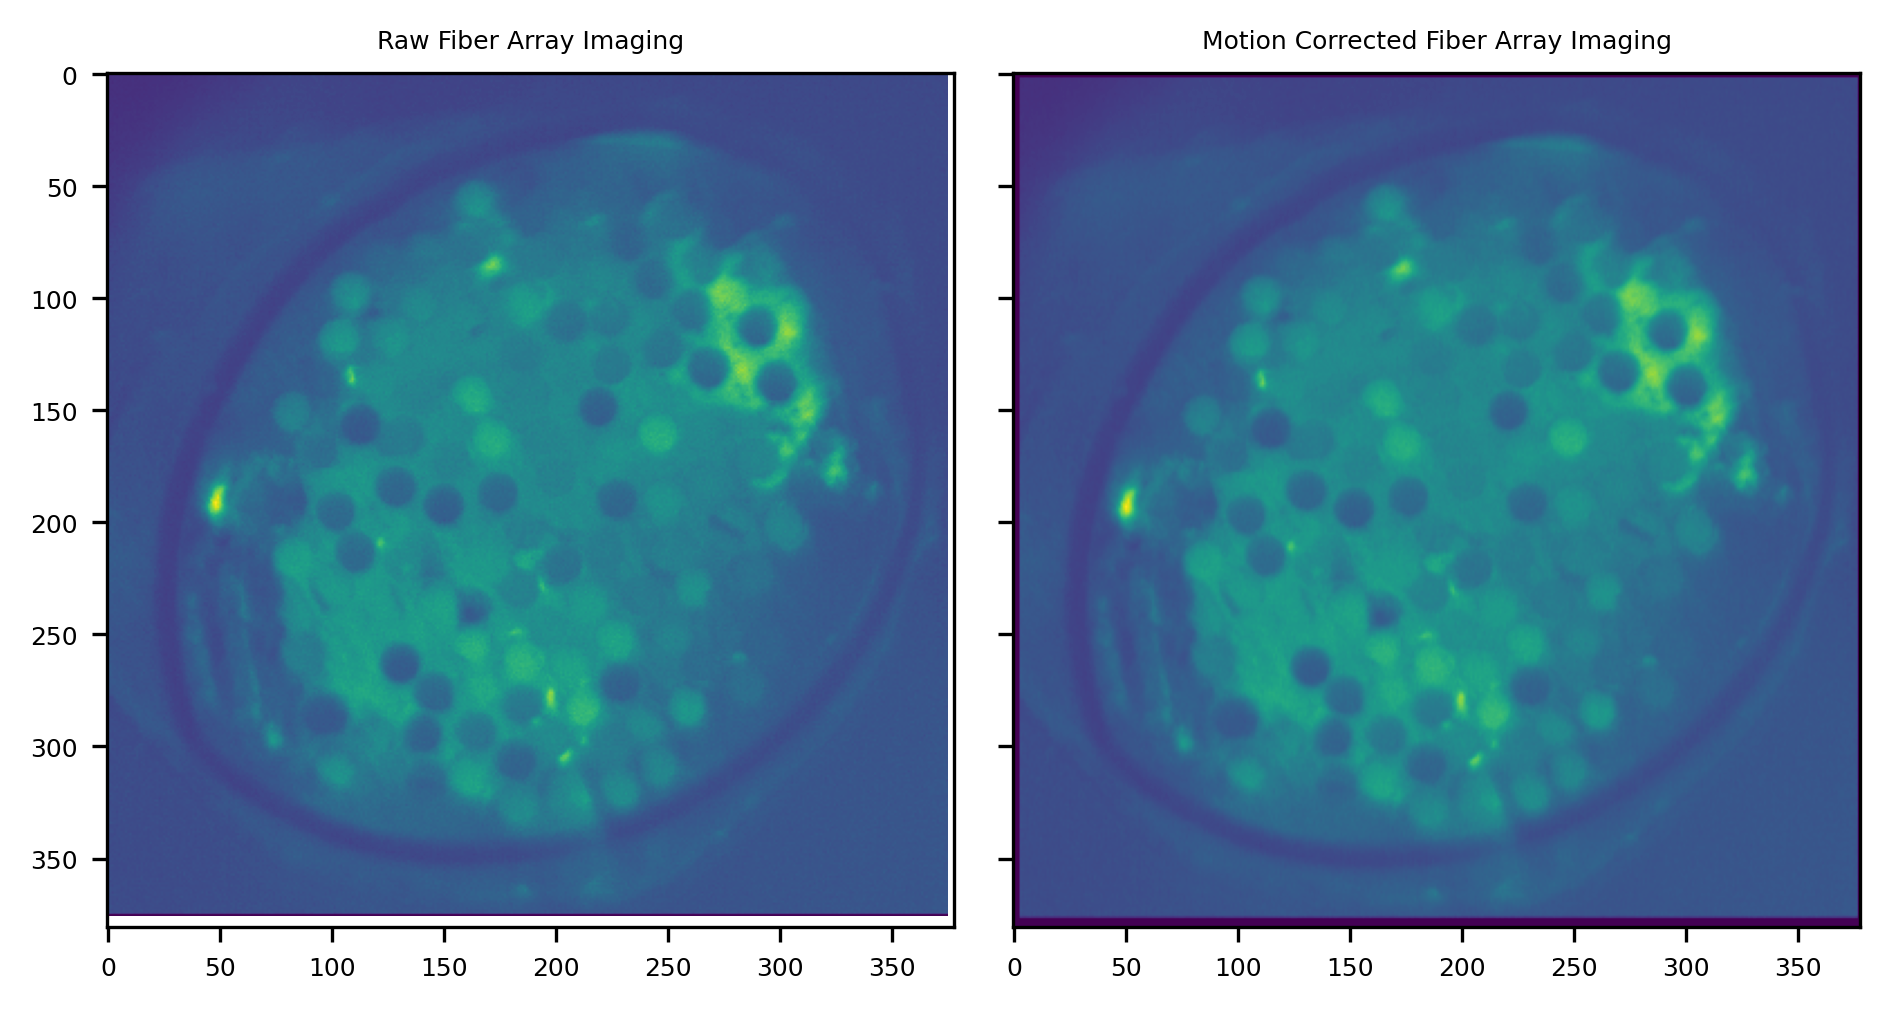

In [27]:
# Visualize the motion corrected imaging data.

from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, dpi=300)

axes[0].imshow(two_photon_series.data[50])
axes[0].set_title("Raw Fiber Array Imaging", fontsize=6)
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)

axes[1].imshow(motion_corrected.data[50])
axes[1].set_title("Motion Corrected Fiber Array Imaging", fontsize=6)
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)

plt.tight_layout()
plt.show()

## Access ROIs <a name="access-motion-corrected"></a>

This section demonstrates how to access the ROIs corresponding to fiber tops in the NWBFile.

The centroids and image masks of the ROIs are stored in a `PlaneSegmentation` added to an `ImageSegmentation` object in `nwbfile.processing["ophys"]`.


In [28]:
rois_table = nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"][:]
rois_table.head()

,image_mask,ROICentroids,Accepted,Rejected
id,,,,
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[166.47541258012367, 59.00562445763765]",0,1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[163.1369152701555, 80.29428559091824]",0,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[144.14977970147507, 83.10331721340896]",0,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[123.4401911607665, 85.54001655461578]",0,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[111.00957492596739, 100.35934701854168]",0,1


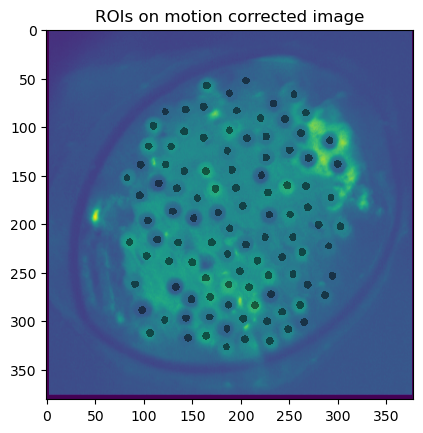

In [29]:
# Visualize the ROIs and the motion corrected imaging data.
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(motion_corrected.data[50])

roi_masks = rois_table["image_mask"].values
roi_masks_combined = np.zeros(roi_masks[0].shape)
for i in range(roi_masks.shape[0]):
    inds = np.where(roi_masks[i] != 0)
    roi_masks_combined[inds] = 1

masked_roi_masks_combined = np.ma.masked_where(roi_masks_combined == 0, roi_masks_combined)
plt.imshow(masked_roi_masks_combined, cmap='gray', interpolation='none', alpha=0.5)
plt.title("ROIs on motion corrected image")
plt.show()

# Access behavior data <a name="access-behavior"></a>

This section demonstrates how to access the behavior data in the NWBFile.

The velocity for the roll and pitch (x, y) measured in m/s is added to `nwbfile.processing["behavior"]` stored in a [pynwb.base.TimeSeries](https://pynwb.readthedocs.io/en/stable/pynwb.base.html#pynwb.base.TimeSeries) object. It can be accessed as `nwbfile.processing["behavior"]["Velocity"]`. 

The angular velocity from yaw (rotational) velocity is converted to radians/s and is also stored in a [pynwb.base.TimeSeries](https://pynwb.readthedocs.io/en/stable/pynwb.base.html#pynwb.base.TimeSeries) object. 
It can be accessed as `nwbfile.processing["behavior"]["AngularVelocity"]`.

In [31]:
nwbfile.processing["behavior"]

In [33]:
velocity = nwbfile.processing["behavior"]["Velocity"]
velocity

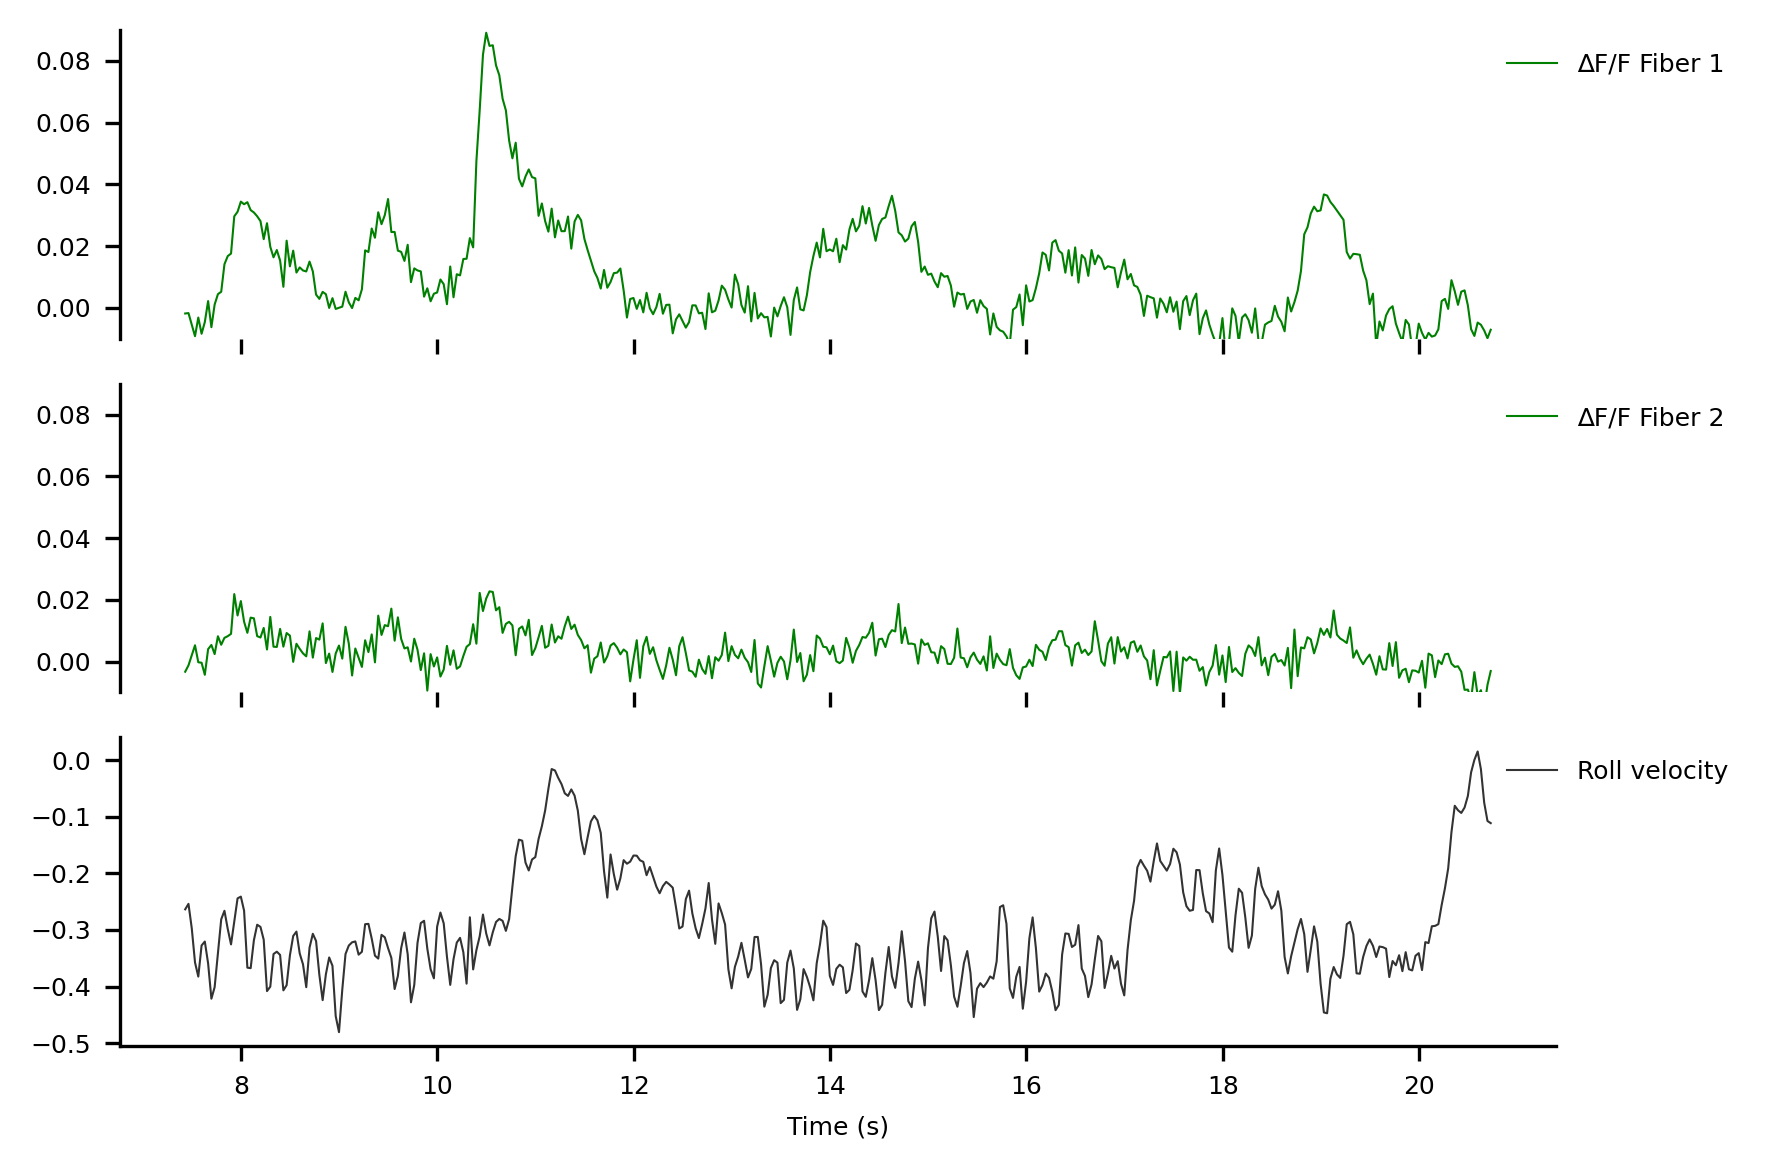

In [34]:
# Visualize the DF/F traces and velocity for the roll in m/s.

import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = df_over_f_traces.data[200:600, :2]
timestamps = df_over_f_traces.get_timestamps()[200:600]

velocity_x = velocity.data[200:600, 0]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 4), sharey=False, sharex=True, dpi=300)

for i in range(len(axes)-1):
    axes[i].plot(timestamps, data[:, i], linewidth=0.5, color="green")
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    axes[i].tick_params(axis='y', labelsize=6)
    axes[i].tick_params(axis='x', labelsize=6)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].set_ylim([-0.01, 0.09])

    axes[i].legend([f"∆F/F Fiber {i+1}"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 6})

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
            
axes[-1].plot(timestamps, velocity_x, color="black", alpha=0.8, linewidth=0.5)
axes[-1].spines['top'].set_visible(False)
axes[-1].spines['right'].set_visible(False)
axes[-1].legend(["Roll velocity"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 6})
axes[-1].tick_params(axis='y', labelsize=6)
axes[-1].tick_params(axis='x', labelsize=6)

plt.xlabel('Time (s)', fontsize=6)
plt.tight_layout()
plt.show()

The onset times of the events (licking, tone, light or reward delivery) are added to `nwbfile.processing["behavior"]["TimeIntervals"]` table.

In [35]:
events = nwbfile.processing["behavior"]["TimeIntervals"][:]
events

,start_time,stop_time,event_type
id,,,
0,10.21300,11.08000,Light
1,25.31550,26.18225,Light
2,36.25050,37.58400,Tone
3,69.78875,70.65550,Light
4,87.65825,88.99175,Tone
...,...,...,...
158,1312.37725,1312.54400,Lick
159,1313.64425,1313.74425,Lick
160,1318.24500,1319.07825,Light


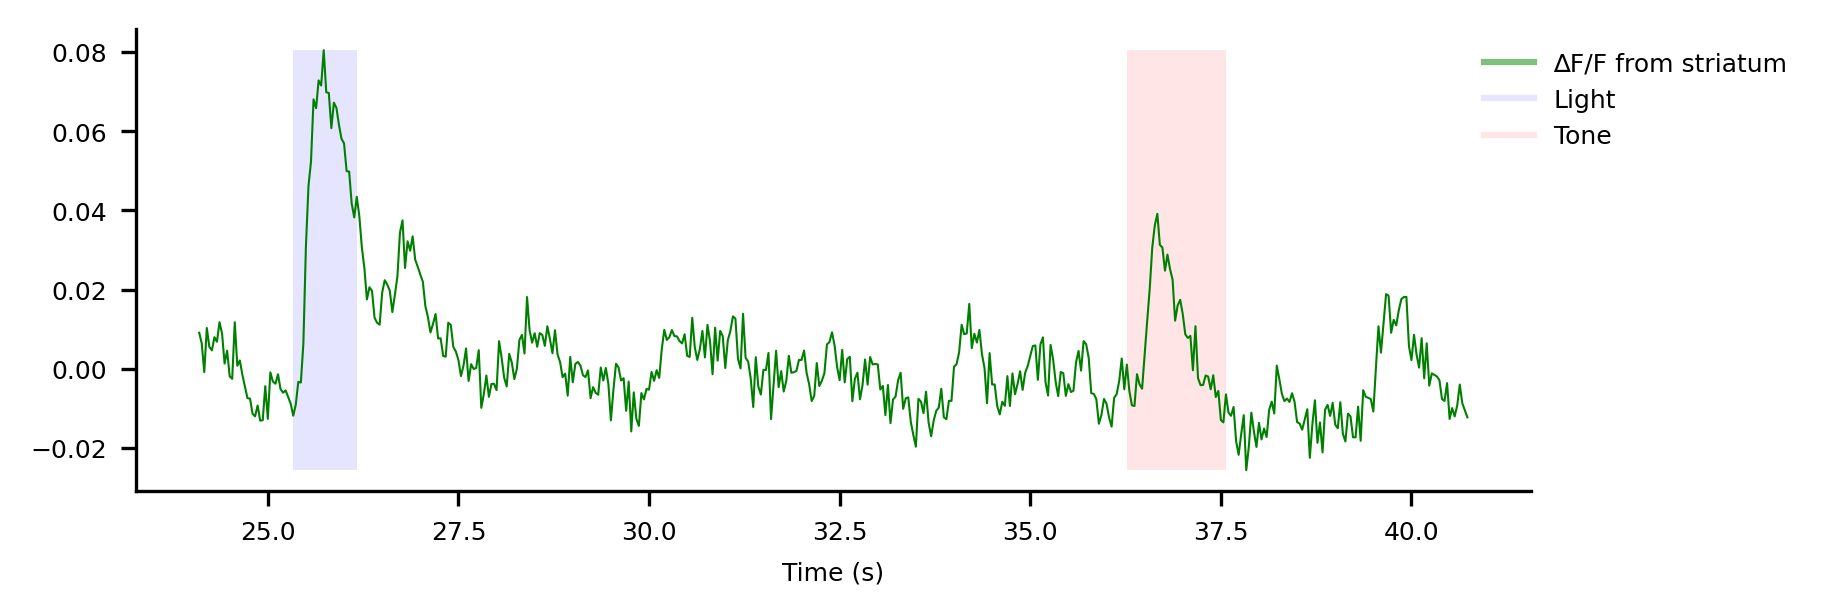

In [36]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

# Prepare data for plotting
data = df_over_f_traces.data[700:1200, 0]
timestamps = df_over_f_traces.get_timestamps()[700:1200]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2), dpi=300, sharex=True)

light_events = events[events["event_type"] == "Light"]
light_events = light_events[(light_events["start_time"] >= timestamps[0]) & (light_events["stop_time"] < timestamps[-1])]

tone_events = events[events["event_type"] == "Tone"]
tone_events = tone_events[(tone_events["start_time"] >= timestamps[0]) & (tone_events["stop_time"] < timestamps[-1])]

ax.plot(timestamps, data, color="green", linewidth=0.5)

for ind, row in light_events.iterrows():
    ax.fill_between(timestamps, min(data), max(data), where=(timestamps >= row["start_time"]) & (timestamps <= row["stop_time"]), color='blue', edgecolor='none', alpha=0.1)

for ind, row in tone_events.iterrows():
    ax.fill_between(timestamps, min(data), max(data), where=(timestamps >= row["start_time"]) & (timestamps <= row["stop_time"]), color='red', edgecolor='none', alpha=0.1)

# Create proxy lines for legend entries with corresponding colors and transparency
green_line = mlines.Line2D([], [], color='green', label='∆F/F from striatum', alpha=0.5)
blue_line = mlines.Line2D([], [], color='blue', label='Light', alpha=0.1)
red_line = mlines.Line2D([], [], color='red', label='Tone', alpha=0.1)

ax.legend(handles=[green_line, blue_line, red_line], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 6})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='x', labelsize=6)
plt.xlabel('Time (s)', fontsize=6)

plt.show()